In [1]:
import numpy as np
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split as split
import matplotlib.pyplot as plt

# 1. Multi-Armed Bandit Problems
We study the classical multi-armed bandit problem specified by a set of real-valued
distributions $ (\nu_a)_{a \in \mathcal{A}}$ with means $(\mu_a)_{a \in \mathcal{A}} \in \mathbb{R}^\mathcal{A}$, where $\mathcal{A}$ is a finite set of arms.
## 1.1 Bandit Arms

In [2]:
# A generic bandit arm class has one
# method to sample a reward from a probability distribution

class Arm:
    def __init__(self, mean: float):
        self.mean = mean
        pass
    def sample(self):
        raise NotImplementedError

# For example, a Bernoulli bandit arm looks like this
class BernoulliArm(Arm):
    def __init__(self, p:float):
        # create a Bernoulli arm with mean p
        super().__init__(mean=p)

    def sample(self):
        # generate a reward from a Bernoulli arm
        return np.random.random() < self.mean

class ExponentialArm(Arm):
    def __init__(self, beta:float):
        super().__init__(mean=beta)

    def sample(self):
        return np.random.exponential(scale=self.mean)

## 1.2 Exercise 1: Implement a bandit arm class with Gaussian distribution.

In [3]:
class GaussianArm(Arm):
    def __init__(self, mean: float, var: float):
        super().__init__(mean=mean)
        self.var = var

    def sample(self):
        return np.random.normal(loc=self.mean, scale=np.sqrt(self.var))

## 1.3 A Multi-Armed Bandit (MAB).

In [4]:
# We now write a generic MAB problem.
# When pulling arm K of a bandit problem, a learning agent gets an instantinuous
# reward and a regret value that is the difference between this reward and the best
# mean over all arms.

class MAB:
    def __init__(self, arms: list[Arm]):
        self.arms = arms
        # We compute the max over arms means for regret computations
        self.best_arm_mean = max([arm.mean for arm in self.arms])

    def sample(self, arm_number: int):
        reward = self.arms[arm_number].sample()
        regret = self.best_arm_mean - reward
        return reward, regret

# A bandit problem with two exponential arms and one Bernoulli arm
test_mab = MAB([ExponentialArm(beta=0.3), ExponentialArm(beta=0.1), BernoulliArm(p=0.7)])
reward, regret = test_mab.sample(arm_number=0)

## 1.4 Exercise 2: Implement a simple MAB class where all the arms are Bernoulli distributed. Instantiate this class by passing a list of means.

In [5]:
class MABBernoulli(MAB):
    def __init__(self, list_means: list[float]):
        list_arms = []
        for mean in list_means:
            list_arms.append(BernoulliArm(p=mean))
        super().__init__(arms=list_arms)
        #super().__init__([BernoulliArm(mean) for mean in list_means])

## 1.6 Cumultative Regret Minimization
At each time $t \geq 1$, a learner must choose an arm $a_t \in \mathcal{A}$, based only on
the past. The learner then receives and observes a reward $X_t$ sampled according to $\nu_{a_t}$. The goal of the learner is simply to maximize the expected sum of rewards received over time, or equivalently minimize regret
with respect to the strategy constantly receiving the highest mean reward.

In [6]:
# Bandit algorithms learn arm pulling strategies to minimize the cumulative regret over T pulls.
def cumul_regret(regrets: list[float]):
    return np.cumsum(regrets)

# 2. Bandit Algorithms
## 2.1 Uniform Sampling

In [7]:
# A bandit algorithm has one key component which is the sampling strategy (which arm to pull ater T pulls).

class BanditAlgo:
    def __init__(self, mab: MAB):
        self.mab = mab
        self.rewards = []
        self.regrets = []
        self.arms_drawn = []

    def sampling(self, timesteps_T: int):
        # Where to implement the sampling strategies
        raise NotImplementedError

# The most naive bandit algorithm is to draw arms at random.
class UniformSamplingAlgo(BanditAlgo):
    def __init__(self, mab: MAB):
        super().__init__(mab=mab)

    def sampling(self, timesteps_T: int):
        for i in range(timesteps_T):
            arm_to_pull = np.random.randint(0, len(self.mab.arms))
            reward, regret = self.mab.sample(arm_to_pull)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)

In [8]:
# Other naive algorithms include Follow the Leader and Explore then Commit. They
# both sample each arm at least once before pulling the best arm for the rest of
# the time.
class FollowTheLeader(BanditAlgo):
    def __init__(self, mab: MAB):
        super().__init__(mab=mab)

    def sampling(self, timesteps_T: int):
        if len(self.mab.arms) > timesteps_T:
            print("Warning: more arms than timesteps")

        # Pull each arm once
        arm_rewards = [[] for _ in range(len(self.mab.arms))]
        for i in range(len(self.mab.arms)):
            reward, regret = self.mab.sample(i)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(i)
            arm_rewards[i].append(reward)

        # Get the best arm based on empirical means
        empirical_means = [np.mean(rewards) for rewards in arm_rewards]
        best_arm = np.argmax(empirical_means)

        # for the rest of the time, pull the best arm
        for j in range(len(self.mab.arms), timesteps_T):
            reward, regret = self.mab.sample(best_arm)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(best_arm)

class ExploreThenCommit(BanditAlgo):
    def __init__(self, mab: MAB, explore_fraction: float):
        super().__init__(mab=mab)
        self.explore_fraction = explore_fraction

    def sampling(self, timesteps_T: int):
        explore_steps = int(timesteps_T * self.explore_fraction)
        arm_rewards = [[] for _ in range(len(self.mab.arms))]
        
        for i in range(explore_steps):
            arm_to_pull = np.random.randint(0, len(self.mab.arms))
            reward, regret = self.mab.sample(arm_to_pull)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)
            arm_rewards[arm_to_pull].append(reward)

        # Get the best arm based on empirical means
        empirical_means = [np.mean(rewards) if len(rewards) > 0 else -np.inf for rewards in arm_rewards]
        best_arm = np.argmax(empirical_means)

        # for the rest of the time, pull the best arm
        for j in range(explore_steps, timesteps_T):
            reward, regret = self.mab.sample(best_arm)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(best_arm)

In [9]:
# A plotting function
def plot_mean_std_cumul_regret(regret_matrix: list[list[float]], algo_name: str):
    means = regret_matrix.mean(axis=0)
    stds = regret_matrix.std(axis=0)
    plt.plot(means, label=algo_name)
    plt.fill_between(np.arange(len(means)), means - stds, means + stds, alpha = 0.1)


Text(0, 0.5, 'Cumulative Regret')

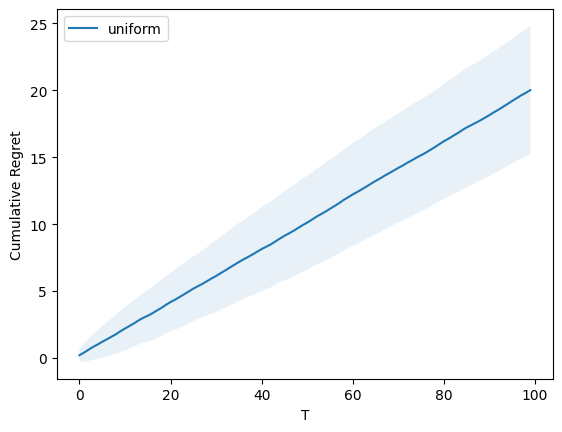

In [10]:
# Example of Uniform Sampling algo on a two-armed Bernoulli bandit

# MAB problem
mab = MAB([BernoulliArm(p=0.2), BernoulliArm(p=0.6)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 100
cum_regrets = np.zeros((repetitions, timesteps_per_repet))

for rep in range(repetitions):
    unif = UniformSamplingAlgo(mab)
    unif.sampling(timesteps_per_repet)
    cum_regrets[rep] = cumul_regret(unif.regrets)
plot_mean_std_cumul_regret(cum_regrets, 'uniform')
plt.legend()
plt.xlabel("T")
plt.ylabel("Cumulative Regret")

## 2.3 Exercise 3: Plot the cumulative regret of bandit algorithms Uniform, FTL, and ETC on a Bernoulli MAB problem. Try different exploration rates for ETC.
Try different MAB Problems (try one with gaussian arms, that have high variance).

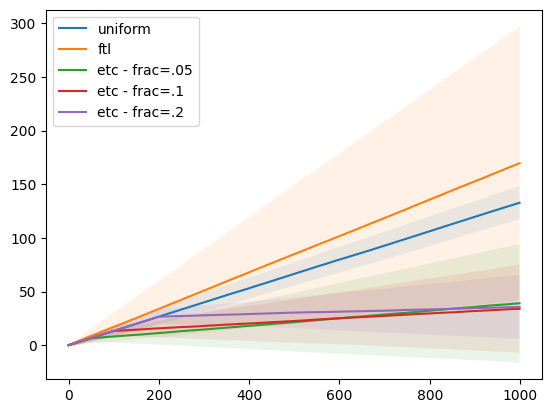

In [11]:
# MAB problem
mab = MAB([BernoulliArm(p=0.2), BernoulliArm(p=0.4), BernoulliArm(p=0.5)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 1000
cum_regrets_uni = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_ftl = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_5 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_10 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_20 = np.zeros((repetitions, timesteps_per_repet))

for rep in range(repetitions):
    unif = UniformSamplingAlgo(mab)
    unif.sampling(timesteps_per_repet)
    cum_regrets_uni[rep] = cumul_regret(unif.regrets)

    ftl = FollowTheLeader(mab)
    ftl.sampling(timesteps_per_repet)
    cum_regrets_ftl[rep] = cumul_regret(ftl.regrets)

    etc5 = ExploreThenCommit(mab, .05)
    etc5.sampling(timesteps_per_repet)
    cum_regrets_etc_5[rep] = cumul_regret(etc5.regrets)

    etc10 = ExploreThenCommit(mab, 0.1)
    etc10.sampling(timesteps_per_repet)
    cum_regrets_etc_10[rep] = cumul_regret(etc10.regrets)

    etc20 = ExploreThenCommit(mab, 0.2)
    etc20.sampling(timesteps_per_repet)
    cum_regrets_etc_20[rep] = cumul_regret(etc20.regrets)

plot_mean_std_cumul_regret(cum_regrets_uni, 'uniform')
plot_mean_std_cumul_regret(cum_regrets_ftl, 'ftl')
plot_mean_std_cumul_regret(cum_regrets_etc_5, 'etc - frac=.05')
plot_mean_std_cumul_regret(cum_regrets_etc_10, 'etc - frac=.1')
plot_mean_std_cumul_regret(cum_regrets_etc_20, 'etc - frac=.2')
plt.legend()

In [12]:
def simulate(mab, algo, timesteps_per_repet, repetitions, **kwargs):
    cum_regrets = np.zeros((repetitions, timesteps_per_repet))
    for rep in range(repetitions):
        exp = algo(mab, **kwargs)
        exp.sampling(timesteps_per_repet)
        cum_regrets[rep] = cumul_regret(exp.regrets)
    return cum_regrets

In [13]:
# MAB problem
mab = MAB([GaussianArm(mean=0., var=2.),
           GaussianArm(mean=1., var=.5),
           BernoulliArm(p=.5)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 1000

In [14]:
uni_cum_regrets = simulate(mab, UniformSamplingAlgo, timesteps_per_repet, repetitions)
ftc_cum_regrets = simulate(mab, FollowTheLeader, timesteps_per_repet, repetitions)
etc_cum_regrets1 = simulate(mab, ExploreThenCommit, timesteps_per_repet, repetitions, explore_fraction=0.1)
etc_cum_regrets2 = simulate(mab, ExploreThenCommit, timesteps_per_repet, repetitions, explore_fraction=0.5)

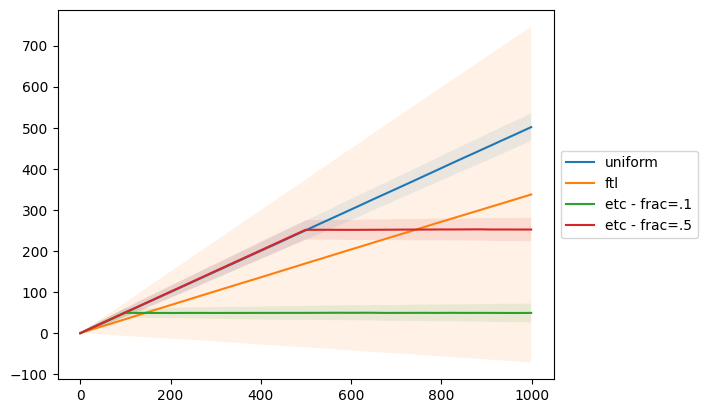

In [15]:
plot_mean_std_cumul_regret(uni_cum_regrets, 'uniform')
plot_mean_std_cumul_regret(ftc_cum_regrets, 'ftl')
plot_mean_std_cumul_regret(etc_cum_regrets1, 'etc - frac=.1')
plot_mean_std_cumul_regret(etc_cum_regrets2, 'etc - frac=.5')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

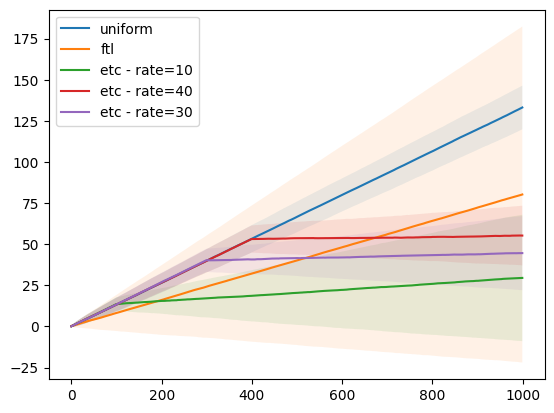

In [16]:
# MAB problem
mab = MAB([ExponentialArm(beta=0.2), ExponentialArm(beta=0.4), ExponentialArm(beta=0.5)])
# Experimental Setup
repetitions = 1000
timesteps_per_repet = 1000
cum_regrets_uni = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_ftl = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_5 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_10 = np.zeros((repetitions, timesteps_per_repet))
cum_regrets_etc_20 = np.zeros((repetitions, timesteps_per_repet))

for rep in range(repetitions):
    unif = UniformSamplingAlgo(mab)
    unif.sampling(timesteps_per_repet)
    cum_regrets_uni[rep] = cumul_regret(unif.regrets)

    ftl = FollowTheLeader(mab)
    ftl.sampling(timesteps_per_repet)
    cum_regrets_ftl[rep] = cumul_regret(ftl.regrets)

    etc5 = ExploreThenCommit(mab, 0.1)
    etc5.sampling(timesteps_per_repet)
    cum_regrets_etc_5[rep] = cumul_regret(etc5.regrets)

    etc10 = ExploreThenCommit(mab, 0.4)
    etc10.sampling(timesteps_per_repet)
    cum_regrets_etc_10[rep] = cumul_regret(etc10.regrets)

    etc20 = ExploreThenCommit(mab, 0.3)
    etc20.sampling(timesteps_per_repet)
    cum_regrets_etc_20[rep] = cumul_regret(etc20.regrets)

plot_mean_std_cumul_regret(cum_regrets_uni, 'uniform')
plot_mean_std_cumul_regret(cum_regrets_ftl, 'ftl')
plot_mean_std_cumul_regret(cum_regrets_etc_5, 'etc - rate=10')
plot_mean_std_cumul_regret(cum_regrets_etc_10, 'etc - rate=40')
plot_mean_std_cumul_regret(cum_regrets_etc_20, 'etc - rate=30')
plt.legend()

# 3. Advanced Bandit Algorithms
## 3.1 Exercise 4: Implement the Upper Confidence Bounds algorithm

For all arm $a \in \mathcal{A}$, for all time step $t \geq 1$, the empirical mean of arm $a$ at time $t$ is 
$$\hat{\mu}_a(t) = \frac{1}{N_a(t)} \sum\limits_{s=1}^t \mathbb{1}_{\{a_s = a\}}X_s\,, $$
and the number of pulls of arm $a$ at time $t$ is
$$N_a(t) = \sum\limits_{s=1}^t \mathbb{1}_{\{a_s = a\}} \,.$$

UCB is the strategy that consists in pulling at time $t$ the arm:
$$ a_{t+1} = \arg\!\max_{a \in \mathcal{A}} \left( \hat{\mu}_a(t) + \sqrt{\frac{2 \log T}{N_a(t)}} \right) \,.$$

In [17]:
class UpperConfBounds(BanditAlgo):
    def __init__(self, mab: MAB):
        super().__init__(mab=mab)
        self.Qs = [[] for arm in self.mab.arms]
        self.Ns = [0 for arm in self.mab.arms]

    def sampling(self, timesteps_T: int):
        for i in range(timesteps_T):
            if i < len(self.mab.arms):
                arm_to_pull = i
                self.Ns[arm_to_pull] += 1
                reward, regret = self.mab.sample(arm_to_pull)
                self.Qs[arm_to_pull].append(reward)
                self.rewards.append(reward)
                self.regrets.append(regret)
                self.arms_drawn.append(arm_to_pull)
            else:
                Ua_t = [np.mean(q) + np.sqrt(2*np.log(timesteps_T) / n) for q, n in zip(self.Qs, self.Ns)]
                arm_to_pull = np.argmax(Ua_t)
                self.Ns[arm_to_pull] += 1
                reward, regret = self.mab.sample(arm_to_pull)
                self.Qs[arm_to_pull].append(reward)
                self.rewards.append(reward)
                self.regrets.append(regret)
                self.arms_drawn.append(arm_to_pull)

## 3.2 Exercise 5: Implement the Thompson Sampling algorithm [TS](https://) with Beta prior and Bernoulli likelihood
For all arm $a \in \mathcal{A}$, for all time step  $t \geq 1$, the cumulative reward from arm $a$ at time $t$ is $$S_a(t) = \sum\limits_{s = 1}^t \mathbb{1}_{\{a_s = a\}}X_s\,, $$
and the number of pulls of arm $a$ at time $t$ is
$$N_a(t) = \sum\limits_{ s=1}^t \mathbb{1}_{\{ a_s = a\}} \,.$$

In a Bayesian view on the MAB, the $(\mu_a)_{a\in\mathcal{A}}$ are no longer seen as unknown parameters but as (independent)random variables following a uniform distribution. The posterior distribution on the arm $a$ at time $t$ of the bandit game is the distribution of $\mu_a$ conditional to the observations from arm $a$ gathered up to
time $t$ and it is denoted $\pi_a(t)$ . Each sample from arm $a$ leads to an update of this posterior distribution.


TS is the strategy that consists in drawing $\theta_a(t)\sim \pi_a(t)=Beta(S_a(t) + 1, N_a(t) - S_a(t) + 1)$ at time step t and for each arm $a$, then pulling the arm:
$$ a_{t+1} = \arg\!\max_{a \in \mathcal{A}}\theta_a(t)  \,.$$

In [18]:
class ThompsonSampling(BanditAlgo):
    def __init__(self, mab: MAB):
        super().__init__(mab=mab)
        self.S = [0 for _ in range(len(self.mab.arms))]
        self.N = [0 for _ in range(len(self.mab.arms))]

    def sampling(self, timesteps_T: int):
        for t in range(timesteps_T):
            theta = [np.random.beta(self.S[a] + 1, self.N[a] - self.S[a] + 1) for a in range(len(self.mab.arms))]
            arm_to_pull = np.argmax(theta)
            reward, regret = self.mab.sample(arm_to_pull)
            self.N[arm_to_pull] += 1
            self.S[arm_to_pull] += reward
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)

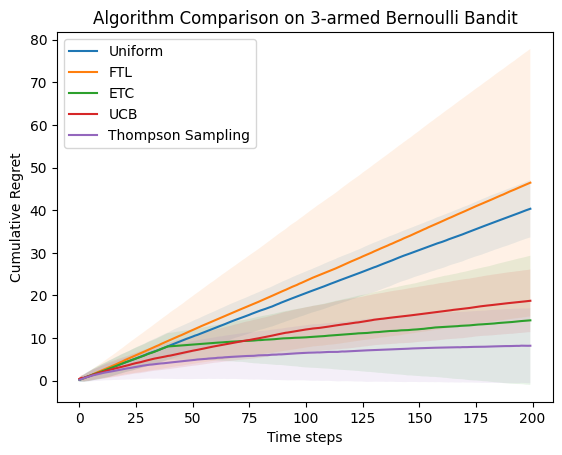

In [19]:
# Compare Thompson Sampling with other algorithms on Bernoulli bandits
mab = MAB([BernoulliArm(p=0.3), BernoulliArm(p=0.5), BernoulliArm(p=0.7)])
repetitions = 1000
timesteps_per_repet = 200

uni_regrets = simulate(mab, UniformSamplingAlgo, timesteps_per_repet, repetitions)
ftl_regrets = simulate(mab, FollowTheLeader, timesteps_per_repet, repetitions)
etc_regrets = simulate(mab, ExploreThenCommit, timesteps_per_repet, repetitions, explore_fraction=0.2)
ucb_regrets = simulate(mab, UpperConfBounds, timesteps_per_repet, repetitions)
ts_regrets = simulate(mab, ThompsonSampling, timesteps_per_repet, repetitions)

plot_mean_std_cumul_regret(uni_regrets, 'Uniform')
plot_mean_std_cumul_regret(ftl_regrets, 'FTL')
plot_mean_std_cumul_regret(etc_regrets, 'ETC')
plot_mean_std_cumul_regret(ucb_regrets, 'UCB')
plot_mean_std_cumul_regret(ts_regrets, 'Thompson Sampling')
plt.legend()
plt.xlabel("Time steps")
plt.ylabel("Cumulative Regret")
plt.title("Algorithm Comparison on 3-armed Bernoulli Bandit")
plt.show()

# 4. Contextual Bandits
## 4.1 Contextual Bandit Arms

In contextual bandits, at each time step $t$, the learner observes a context (feature vector) $\mathbf{x}_t \in \mathbb{R}^d$ for each arm before making a decision. The expected reward of arm $a$ given context $\mathbf{x}_t$ is modeled as:
$$\mathbb{E}[r_{a,t} | \mathbf{x}_{a,t}] = \mathbf{x}_{a,t}^\top \boldsymbol{\theta}_a^*$$

In [20]:
# A contextual arm generates rewards based on a linear model with a context vector
class ContextualArm(Arm):
    def __init__(self, theta: np.ndarray, noise_std: float = 0.1):
        """
        Args:
            theta: True parameter vector of shape (n_features,)
            noise_std: Standard deviation of Gaussian noise
        """
        # The mean is not well-defined for contextual arms (depends on context)
        super().__init__(mean=0.0)
        self.theta = theta
        self.noise_std = noise_std
    
    def sample(self, context: np.ndarray):
        """Generate reward given context: r = x^T theta + noise"""
        return context.dot(self.theta) + np.random.randn() * self.noise_std

In [21]:
# A contextual MAB where arms depend on context vectors
class ContextualMAB(MAB):
    def __init__(self, arms: list[ContextualArm], n_features: int):
        super().__init__(arms)
        self.n_features = n_features
    
    def sample(self, arm_number: int, context: np.ndarray):
        """Sample reward for a given arm and context"""
        reward = self.arms[arm_number].sample(context)
        # Compute regret: difference from best arm for this context
        best_reward = max([arm.theta.dot(context) for arm in self.arms])
        regret = best_reward - self.arms[arm_number].theta.dot(context)
        return reward, regret
    
    def generate_context(self):
        """Generate a random context vector"""
        return np.random.randn(self.n_features)

## 4.1 Exercise 6: Implement the Linear Upper Confidence Bounds algorithm (LinUCB)

LinUCB maintains for each arm $a$:
- A design matrix $\mathbf{A}_a = \sum_{s=1}^{t-1} \mathbf{x}_{a,s} \mathbf{x}_{a,s}^\top + \lambda \mathbf{I}_d$ 
- A reward vector $\mathbf{b}_a = \sum_{s=1}^{t-1} r_{a,s} \mathbf{x}_{a,s}$

The UCB index for arm $a$ at time $t$ is:
$$\text{UCB}_a(t) = \hat{\boldsymbol{\theta}}_a^\top \mathbf{x}_{a,t} + \alpha \sqrt{\mathbf{x}_{a,t}^\top \mathbf{A}_a^{-1} \mathbf{x}_{a,t}}$$

where $\hat{\boldsymbol{\theta}}_a = \mathbf{A}_a^{-1} \mathbf{b}_a$ and $\alpha > 0$ is the exploration parameter.

In [22]:
class LinUCB(BanditAlgo):
    def __init__(self, mab: ContextualMAB, alpha: float = 1.0, lambda_reg: float = 1.0):
        super().__init__(mab=mab)
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        
        # Initialize A_a and b_a for each arm
        self.A = [lambda_reg * np.eye(mab.n_features) for _ in range(len(mab.arms))]
        self.b = [np.zeros(mab.n_features) for _ in range(len(mab.arms))]
    
    def compute_ucb_index(self, arm: int, context: np.ndarray) -> float:
        A_inv = np.linalg.inv(self.A[arm])
        theta_hat = A_inv.dot(self.b[arm])
        ucb = theta_hat.dot(context) + self.alpha * np.sqrt(context.dot(A_inv).dot(context))
        return ucb
    
    def sampling(self, timesteps_T: int):
        for t in range(timesteps_T):
            # Generate context
            context = self.mab.generate_context()
            
            # Compute UCB index for all arms
            ucb_indices = [self.compute_ucb_index(arm, context) for arm in range(len(self.mab.arms))]
            arm_to_pull = np.argmax(ucb_indices)
            
            # Pull arm and observe reward
            reward, regret = self.mab.sample(arm_to_pull, context)
            self.rewards.append(reward)
            self.regrets.append(regret)
            self.arms_drawn.append(arm_to_pull)
            
            # Update statistics
            self.A[arm_to_pull] += np.outer(context, context)
            self.b[arm_to_pull] += reward * context

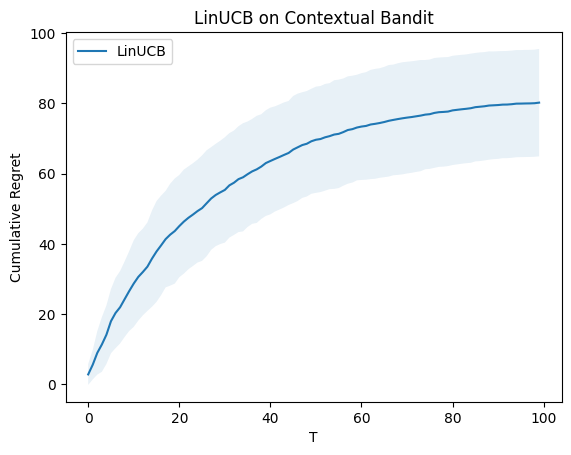

In [23]:
# Experiment with LinUCB on a contextual bandit problem

# Create contextual MAB with 5 arms and 10-dimensional contexts
n_arms = 5
n_features = 10
np.random.seed(42)
true_thetas = [np.random.randn(n_features) for _ in range(n_arms)]
contextual_arms = [ContextualArm(theta) for theta in true_thetas]
contextual_mab = ContextualMAB(contextual_arms, n_features)

# Run experiment
repetitions = 50
timesteps_per_repet = 100
cum_regrets = np.zeros((repetitions, timesteps_per_repet))

for rep in range(repetitions):
    linucb = LinUCB(contextual_mab, alpha=1.0, lambda_reg=1.0)
    linucb.sampling(timesteps_per_repet)
    cum_regrets[rep] = cumul_regret(linucb.regrets)

plot_mean_std_cumul_regret(cum_regrets, 'LinUCB')
plt.legend()
plt.xlabel("T")
plt.ylabel("Cumulative Regret")
plt.title("LinUCB on Contextual Bandit")
plt.show()